In [1]:
# === Imports & theme ===
import json, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", context="talk")

# === Data inlezen (robust voor list-of-records of {"data": [...]}) ===
PATH = "amsterdam_2023_2024.json"
with open(PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)

records = raw["data"] if isinstance(raw, dict) and "data" in raw else raw
df = pd.json_normalize(records)

# === Datum parsen ===
# Probeer automatisch, anders val terug op KNMI-formaat (YYYYMMDD)
try:
    df["date"] = pd.to_datetime(df["date"])
except Exception:
    df["date"] = pd.to_datetime(df["date"].astype(str), format="%Y%m%d")

# === Hulpfunctie: maak kolom als die bestaat, gedeeld door 10 (KNMI tienden) ===
def make_scaled(src, dest, divisor=10):
    if src in df.columns:
        df[dest] = pd.to_numeric(df[src], errors="coerce") / divisor

# === Veelgebruikte grootheden (als aanwezig) ===
# Temperatuur (°C)
make_scaled("TG", "TG_C")   # daggem. temp
make_scaled("TN", "TN_C")   # dag-min
make_scaled("TX", "TX_C")   # dag-max
make_scaled("T10N", "T10N_C")  # 10cm-min (optioneel)

# Wind (m/s)
make_scaled("FG", "FG_ms")    # gem. windsnelheid
make_scaled("FXX", "FXX_ms")  # hoogste windstoot
# Windrichting (graden) zit meestal in DDVEC (al in graden)
if "DDVEC" in df.columns:
    df["DDVEC"] = pd.to_numeric(df["DDVEC"], errors="coerce")

# Neerslag (mm) & verdamping (mm)
make_scaled("RH", "RH_mm")     # neerslagsom
make_scaled("EV24", "EV24_mm") # verdamping

# Zonduur (uren) — KNMI 'SQ' is in tienden van uren
make_scaled("SQ", "SQ_h")      

# Luchtdruk (hPa)
make_scaled("PG", "PG_hPa")  # daggemiddelde druk
make_scaled("PX", "PX_hPa")  # dag-maximum
make_scaled("PN", "PN_hPa")  # dag-minimum

# === Tijdsfeatures ===
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["week"] = df["date"].dt.isocalendar().week.astype(int)
df["weekday"] = df["date"].dt.weekday  # 0=maandag

# Seizoen (NL)
def season(m):
    return ("winter" if m in [12,1,2] else
            "lente"  if m in [3,4,5] else
            "zomer"  if m in [6,7,8] else
            "herfst")
df["season"] = df["month"].apply(season)

df.head()


,station_code,date,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,SQ_h,PG_hPa,PX_hPa,PN_hPa,year,month,day,week,weekday,season
0,240,2023-01-01 00:00:00+00:00,212,73,80,120,3,40,21,200,...,1.8,1010.7,1013.4,1005.7,2023,1,1,52,6,winter
1,240,2023-01-02 00:00:00+00:00,240,44,50,70,5,30,20,110,...,0.2,1016.0,1024.9,1007.7,2023,1,2,1,0,winter
2,240,2023-01-03 00:00:00+00:00,181,57,59,110,22,10,3,160,...,0.6,1023.0,1025.5,1015.8,2023,1,3,1,1,winter
3,240,2023-01-04 00:00:00+00:00,235,124,127,150,10,100,24,210,...,0.0,1012.6,1014.9,1011.2,2023,1,4,1,2,winter
4,240,2023-01-05 00:00:00+00:00,242,67,73,100,2,50,16,150,...,1.0,1017.8,1019.7,1015.1,2023,1,5,1,3,winter


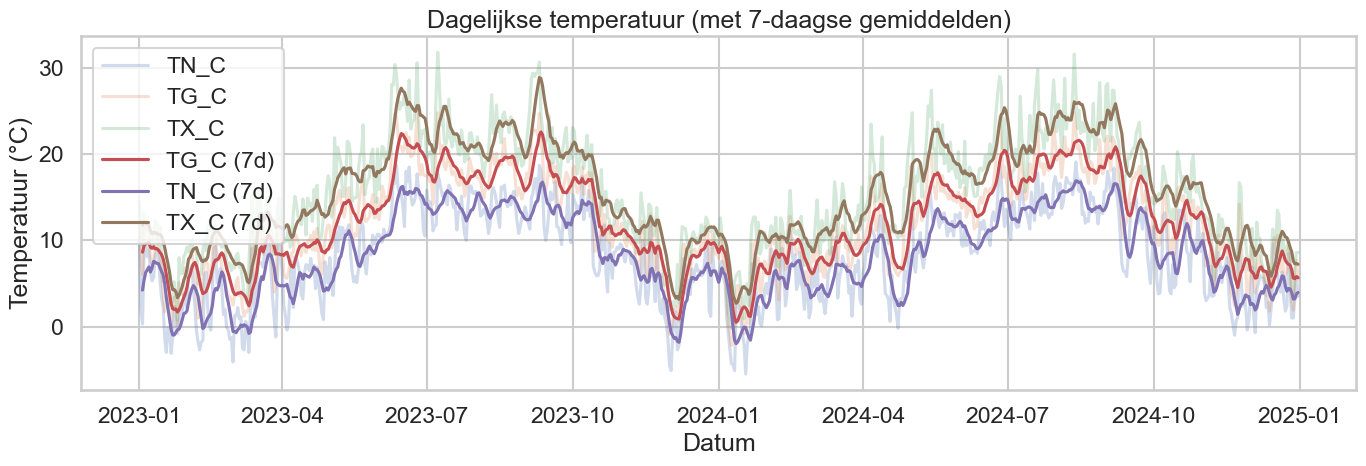

In [2]:
use_cols = [c for c in ["TN_C","TG_C","TX_C"] if c in df.columns]
assert use_cols, "Geen temperatuurkolommen gevonden (TN/TG/TX)."

# Long-form voor seaborn
temp = df[["date"] + use_cols].melt("date", var_name="type", value_name="temp_C")

plt.figure(figsize=(14,5))
ax = sns.lineplot(data=temp, x="date", y="temp_C", hue="type", alpha=0.25)
# 7-daagse rolling mean voor rustiger beeld
for name, sub in temp.groupby("type"):
    sub = sub.sort_values("date").copy()
    sub["roll"] = sub["temp_C"].rolling(7, min_periods=3).mean()
    sns.lineplot(data=sub, x="date", y="roll", label=f"{name} (7d)", ax=ax)

ax.set_title("Dagelijkse temperatuur (met 7-daagse gemiddelden)")
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatuur (°C)")
plt.tight_layout()
plt.show()


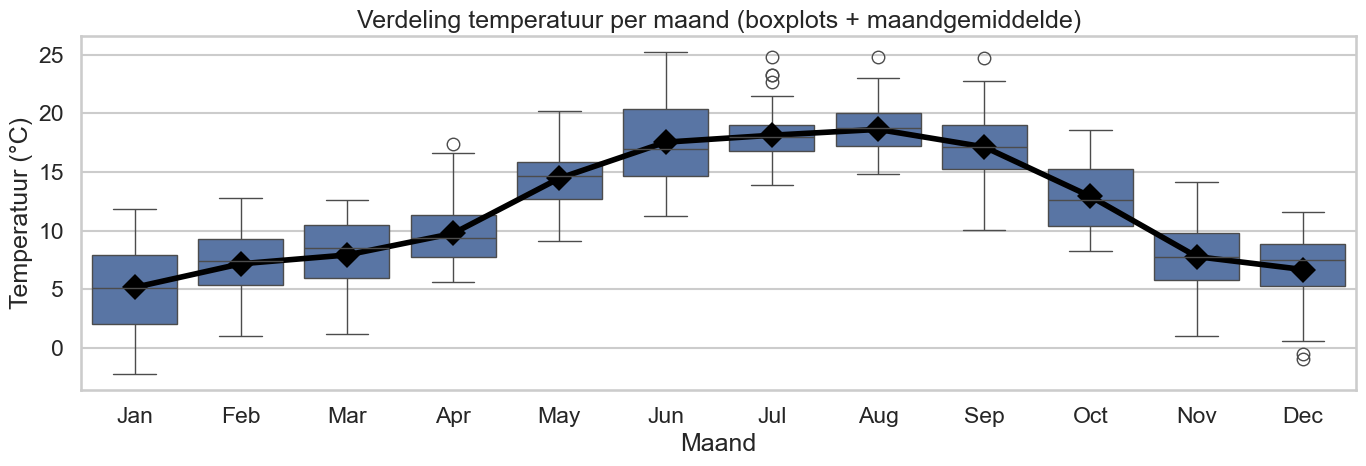

In [3]:
import calendar

assert "TG_C" in df.columns, "TG_C niet beschikbaar; draai Blok 0 en check TG."

# Maandnaam (NL-agnostisch): gebruik afgekorte Engelse + mapping, of toon getal
month_order = list(range(1,13))
df["month_label"] = df["month"].map(lambda m: calendar.month_abbr[m])

plt.figure(figsize=(14,5))
ax = sns.boxplot(data=df, x="month_label", y="TG_C",
                 order=[calendar.month_abbr[m] for m in month_order])
sns.pointplot(data=df, x="month_label", y="TG_C",
              order=[calendar.month_abbr[m] for m in month_order],
              estimator=np.mean, errorbar=None, markers="D", color="black", ax=ax)
ax.set_title("Verdeling temperatuur per maand (boxplots + maandgemiddelde)")
ax.set_xlabel("Maand")
ax.set_ylabel("Temperatuur (°C)")
plt.tight_layout()
plt.show()


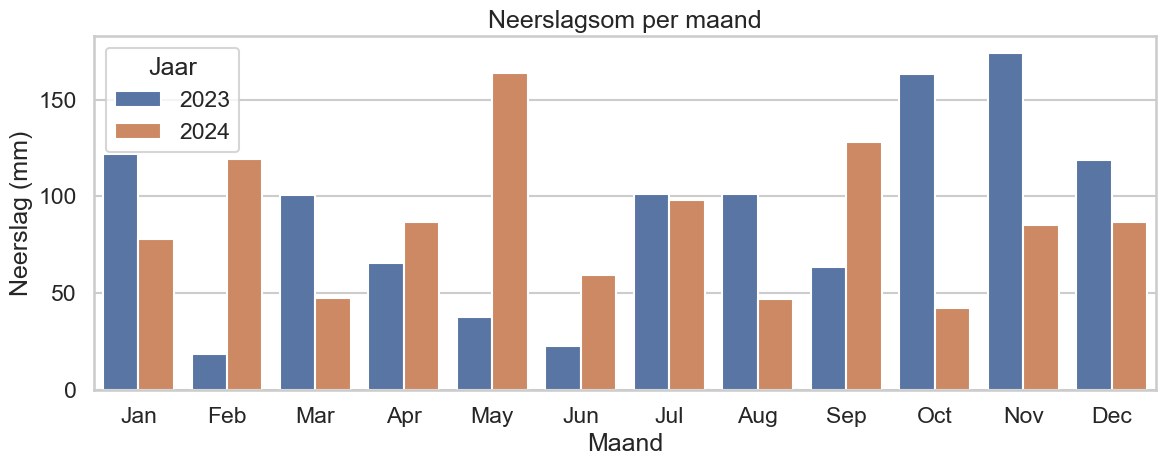

In [4]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

assert {"RH_mm","year","month"}.issubset(df.columns), "Mis kolommen: RH_mm/year/month"

# Aggregatie: neerslagsom per maand per jaar
monthly = (df.assign(year_str=df["year"].astype(str))
             .groupby(["year_str","month"], as_index=False)["RH_mm"]
             .sum())

# Maandlabels en vaste volgorde (jan..dec)
monthly["month_label"] = monthly["month"].map(lambda m: calendar.month_abbr[m])
month_order = [calendar.month_abbr[m] for m in range(1,13)]
hue_order = sorted(monthly["year_str"].unique())

plt.figure(figsize=(12,5))
ax = sns.barplot(
    data=monthly,
    x="month_label", y="RH_mm",
    hue="year_str",
    order=month_order,
    hue_order=hue_order,
    dodge=True
)
ax.set_title("Neerslagsom per maand")
ax.set_xlabel("Maand")
ax.set_ylabel("Neerslag (mm)")
ax.legend(title="Jaar")
plt.tight_layout()
plt.show()



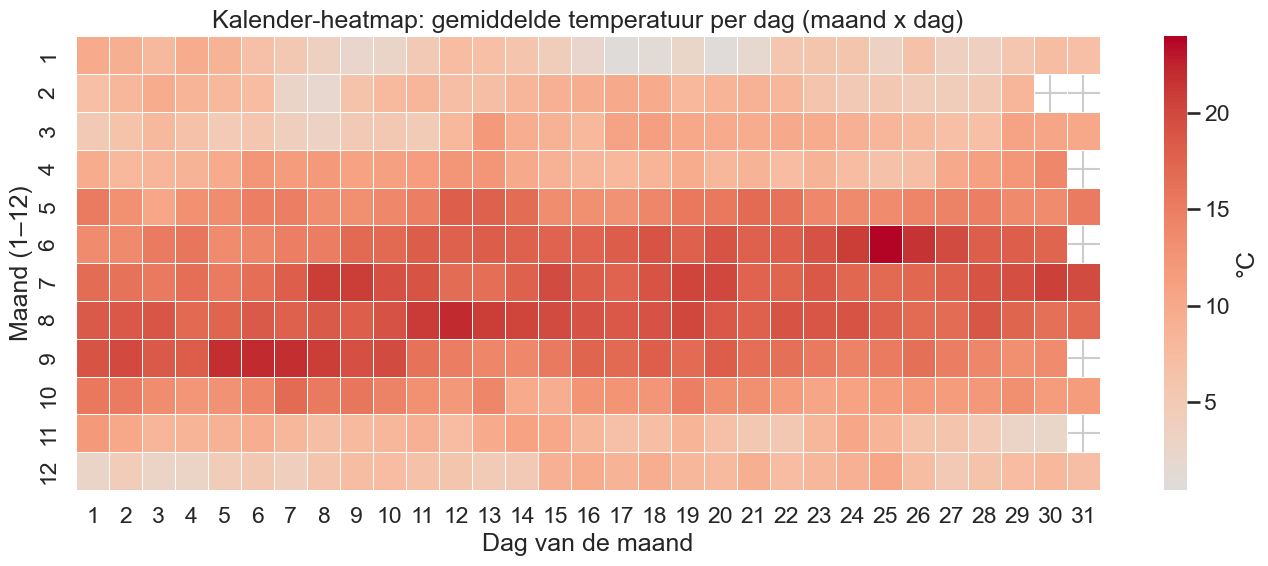

In [10]:
assert "TG_C" in df.columns, "TG_C niet beschikbaar."

# Pivot: rijen = maand, kolommen = dag van de maand
pivot = df.pivot_table(index="month", columns="day", values="TG_C", aggfunc="mean")
plt.figure(figsize=(14,6))
ax = sns.heatmap(pivot, cmap="coolwarm", center=0, linewidths=.5, linecolor="white",
                 cbar_kws={"label": "°C"})
ax.set_title("Kalender-heatmap: gemiddelde temperatuur per dag (maand x dag)")
ax.set_xlabel("Dag van de maand")
ax.set_ylabel("Maand (1–12)")
plt.tight_layout()
plt.show()

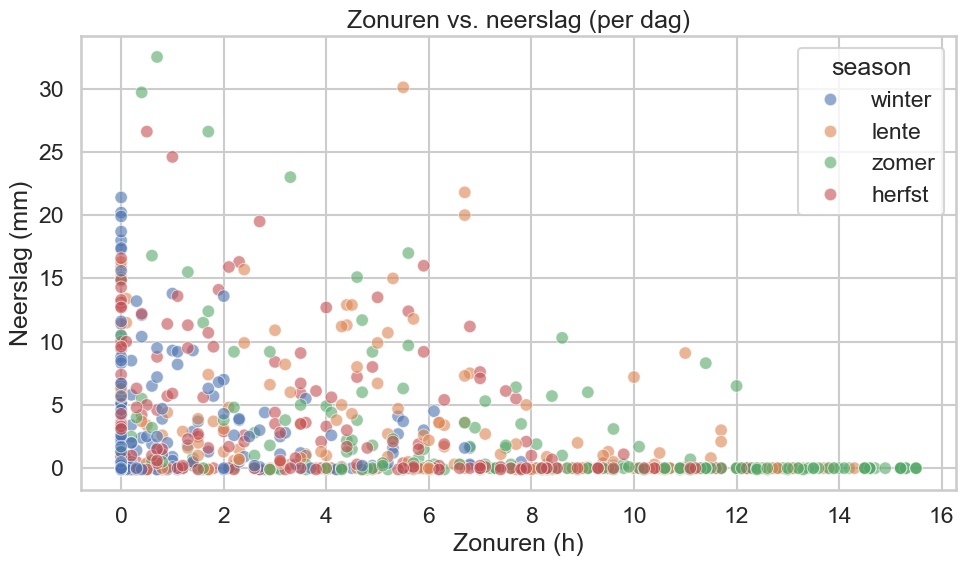

In [6]:
needed = [c for c in ["SQ_h", "RH_mm", "season"] if c in df.columns]
assert all(c in df.columns for c in ["season"]), "Seizoen niet aanwezig (Blok 0)."
if not all(c in df.columns for c in ["SQ_h","RH_mm"]):
    raise AssertionError("SQ_h of RH_mm ontbreekt (check of 'SQ' en 'RH' in data zitten).")

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=df, x="SQ_h", y="RH_mm", hue="season", alpha=0.6)
ax.set_title("Zonuren vs. neerslag (per dag)")
ax.set_xlabel("Zonuren (h)")
ax.set_ylabel("Neerslag (mm)")
plt.tight_layout()
plt.show()


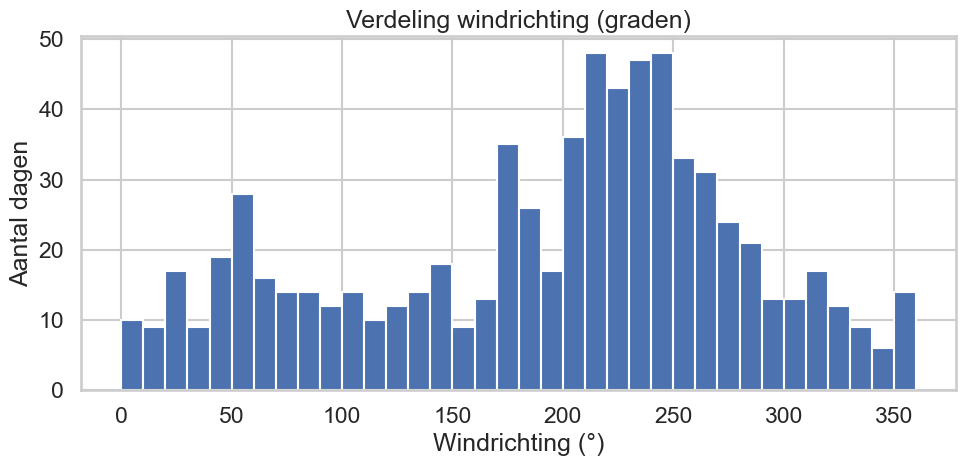

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric & finite
x = pd.to_numeric(df["DDVEC"], errors="coerce")
x = x[np.isfinite(x)]

# 10° bins (0..360)
bins = np.arange(0, 361, 10)

plt.figure(figsize=(10,5))
plt.hist(x, bins=bins, edgecolor="white")
plt.title("Verdeling windrichting (graden)")
plt.xlabel("Windrichting (°)")
plt.ylabel("Aantal dagen")
plt.tight_layout()
plt.show()




In [8]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Zorg dat FG_ms bestaat (gemiddelde m/s)
assert "FG_ms" in df.columns and "DDVEC" in df.columns, "FG_ms of DDVEC ontbreekt."

w = df[["DDVEC", "FG_ms"]].dropna()
ax = WindroseAxes.from_ax()
ax.bar(w["DDVEC"], w["FG_ms"], normed=True, opening=0.8, bins=[0,2,4,6,8,10,12])
ax.set_title("Windroos — richting & snelheid (gemiddeld)")
ax.set_legend(title="m/s")
plt.show()


ModuleNotFoundError: No module named 'windrose'

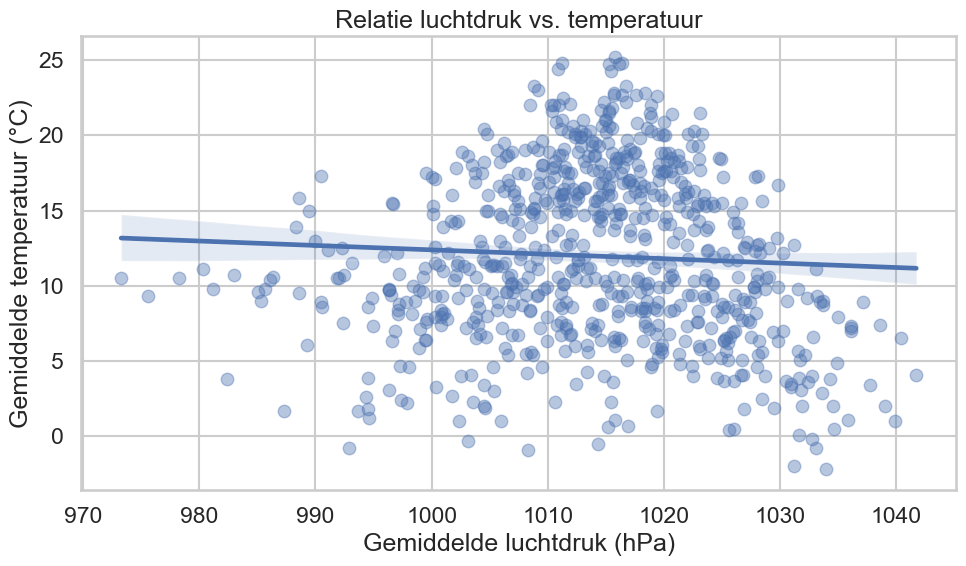

In [ ]:
assert "PG_hPa" in df.columns and "TG_C" in df.columns, "PG_hPa of TG_C ontbreekt."
plt.figure(figsize=(10,6))
ax = sns.regplot(data=df, x="PG_hPa", y="TG_C", scatter_kws={"alpha":0.4})
ax.set_title("Relatie luchtdruk vs. temperatuur")
ax.set_xlabel("Gemiddelde luchtdruk (hPa)")
ax.set_ylabel("Gemiddelde temperatuur (°C)")
plt.tight_layout()
plt.show()


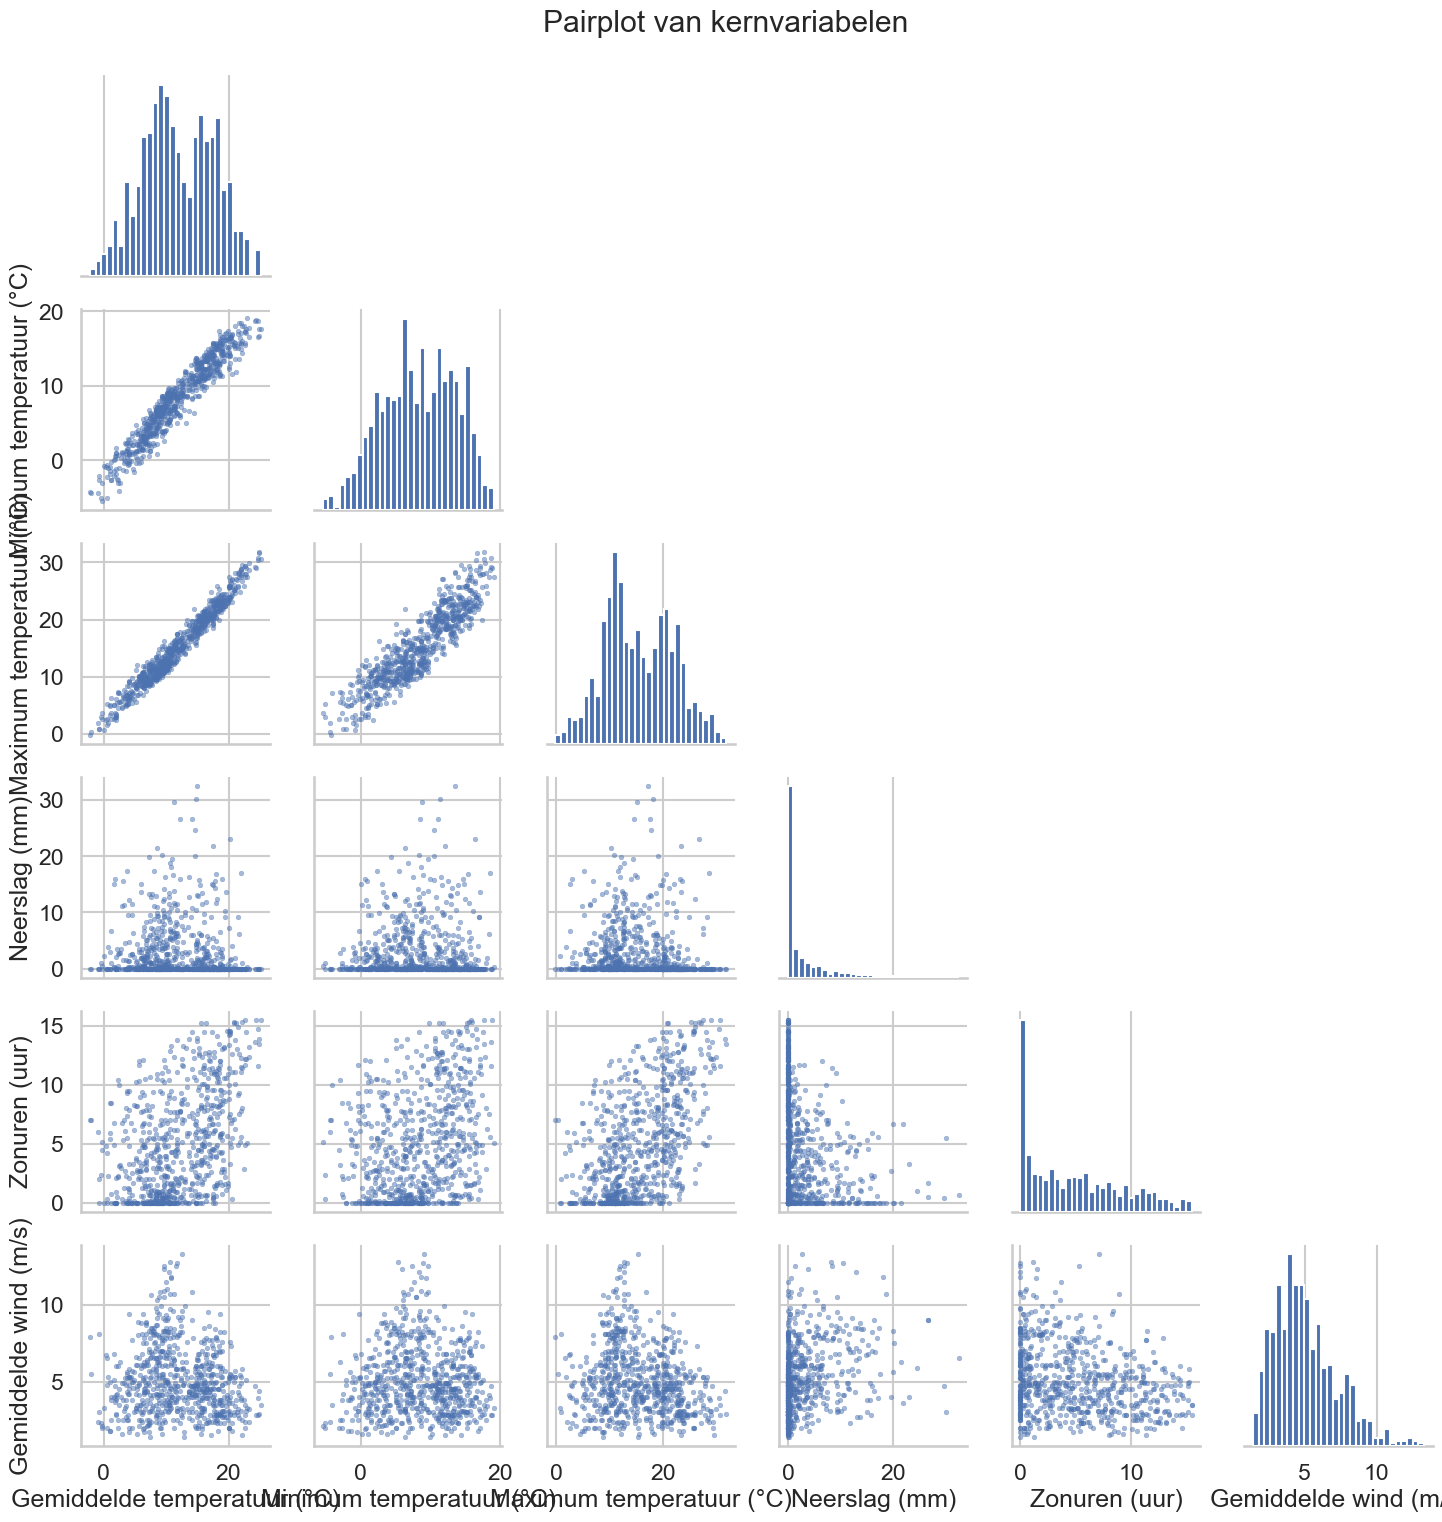

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", context="talk")

# Mooie namen met eenheden
nice_names = {
    "TG_C":  "Gemiddelde temperatuur (°C)",
    "TN_C":  "Minimum temperatuur (°C)",
    "TX_C":  "Maximum temperatuur (°C)",
    "RH_mm": "Neerslag (mm)",
    "SQ_h":  "Zonuren (uur)",
    "FG_ms": "Gemiddelde wind (m/s)",
}

# Gebruik alleen kolommen die er echt zijn
cols = [c for c in nice_names if c in df.columns]
assert len(cols) >= 3, "Te weinig kolommen voor pairplot."

# Numeriek + hernoemen voor nette aslabels
X = (df[cols]
     .apply(pd.to_numeric, errors="coerce")
     .dropna()
     .rename(columns=nice_names))

g = sns.PairGrid(X, corner=True, diag_sharey=False)
g.map_lower(sns.scatterplot, s=12, alpha=0.5, edgecolor=None)
g.map_diag(plt.hist, bins=30)  # Matplotlib-hist op de diagonaal
g.figure.suptitle("Pairplot van kernvariabelen", y=1.02)

plt.show()



In [20]:
import plotly.express as px
import calendar
import locale

# Locale op Nederlands zetten
locale.setlocale(locale.LC_TIME, "nl_NL.UTF-8")  # werkt op Linux/Mac
# op Windows kan het ook "nl_NL" of "nld_NLD" zijn, afhankelijk van je systeem

assert "TG_C" in df.columns, "TG_C niet beschikbaar."

# Pivot: rijen = maand (1–12), kolommen = dag van de maand
pivot = df.pivot_table(index="month", columns="day", values="TG_C", aggfunc="mean")

# Index (1–12) omzetten naar maandnamen in NL
pivot.index = [calendar.month_name[m] for m in pivot.index]

# Heatmap maken met Plotly
fig = px.imshow(
    pivot,
    labels=dict(x="Dag van de maand", y="Maand", color="Gem. Temp (°C)"),
    x=pivot.columns,
    y=pivot.index,
    color_continuous_scale="RdBu_r",  # lijkt op coolwarm
    aspect="auto"
)

fig.update_layout(
    title="Kalender-heatmap: gemiddelde temperatuur per dag (maand x dag)",
    xaxis_title="Dag van de maand",
    yaxis_title="Maand"
)

fig.show()
